<h3>Computational Structural Design and Optimization</h3>
<h3>Assignment #3</h3>

<h3>Problem 2 – Multi-Objective Exploration</h3>

In [1]:
import numpy as np
from scipy import integrate 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import fsolve
import scipy.spatial.distance as dist
import scipy.optimize as optimize
from scipy.optimize import minimize
import math
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import depth_first_tree
import time

from frame3dd import Frame, NodeData, ReactionData, ElementData, Options, \
    StaticLoadCase
    
# from IPython.html.widgets import interact, interactive, fixed
# from IPython.html import widgets

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib notebook
# %matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# %config InlineBackend.figure_formats = {'svg',}
plt.ioff()    # this stops the graphs from overwriting each other

font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

<h3>Define a "Node" class</h3>

In [2]:
class Node:
    def __init__(self, position, index):
        self.position = position
        self.index = index
        self.fixed = False
        self.beams = []
        self.solved = False
        self.externalForces = []
        
    def addBeam(self, beam):
        self.beams.append(beam)
        
    def getPosition(self):
        return self.position
    
    def addExternalForce(self, fv):
        if not (self.fixed):
            self.externalForces.append(fv)
        
    def solveMethodOfJoints(self):
        print(self.index)
        
        if (self.solved):
            return True
        if (self.fixed):
            return True
        
        numUnknowns = 0
        for beam in self.beams:
            beamForce = beam.getForce()
            if (beamForce is None):
                numUnknowns = numUnknowns + 1
        if (numUnknowns > 2):
            return False

        # solvable...
        print("solvable at node " + str(self.index))
        totalForce = np.array([0,0])
        for f in self.externalForces:
            totalForce = totalForce + f
        print("total force = " + str(totalForce))
        
        angles = np.zeros(2)
        beams = []
        i = 0
        thisnode = self
        for beam in self.beams:
            beamForce = beam.getForce()
            if (beamForce is None):
                angles[i] = beam.getAngle(self.position)
                beams.append(beam)
                print("bf = " + str(beamForce) + ",  angle = " + str(angles[i]))
                i = i+1
            else:
                beam_angle = beam.getAngle(thisnode.position)
                print("beam angle = " + str(beam_angle))
                totalForce = totalForce + beamForce
                print("total force = " + str(totalForce))
                
        print(angles)
        cos0 = np.cos(angles[0])
        sin0 = np.sin(angles[0])
        cos1 = np.cos(angles[1])
        sin1 = np.sin(angles[1])
        beam1 = (-totalForce[0]+totalForce[1]*cos0/sin0)/(cos1-sin1*cos0/sin0)
        beam0 = -totalForce[1]/sin0 - beam1*sin1/sin0
        
        beams[0].setForce(beam0,angles[0])
        beams[1].setForce(beam1,angles[1])
        self.solved = True
        return True

<h3>Define a "Beam" class</h3>

In [3]:
class Beam:
    def __init__(self, nodes, index):
        self.nodes = nodes
        self.index = index
        self.vertices = [nodes[0].position, nodes[1].position]
        self.force = None
        self.nodes[0].addBeam(self)
        self.nodes[1].addBeam(self)
        self.vlength = np.sqrt((nodes[1].position[0]-nodes[0].position[0])**2 + \
                              (nodes[1].position[1]-nodes[0].position[1])**2)
    
    def getForce(self):
        if self.force is None:
            return None
        return -self.force
    
    def setForce(self,forceMag,angle):
        self.force = np.array([forceMag*np.cos(angle),forceMag*np.sin(angle)])
    
    def getAngle(self,fromNodePos):
        othernode = 0
        if (fromNodePos == self.vertices[0]):
            othernode = 1
        return np.arctan2(fromNodePos[1]-self.vertices[othernode][1],
                          fromNodePos[0]-self.vertices[othernode][0])
        
    def getLength(self):
        return self.vlength

<h3>Create a function to generate the canopy geometry</h3>

In [4]:
def canopy(x):
    x1 = x[0] # x1 = vetical location of lower support 6 --> 14
    x2 = x[1] # x2 = horiztonal location of canopy tip 10 --> 20
    x3 = x[2] # x3 = vertical location of canopy tip 6 --> 14
    x4 = np.round(x[3]) # x4 = number of cables 2 --> 20
    
    # define array of points and adjacency
    nodes = []
    beams = []
    
    # top cable stay anchor
    nodes.append(Node([0.0,15.0],0))
    nodes[0].fixed = True
    
    # canopy beam
    nodes.append(Node([0.0,x1],1))
    nodes[1].fixed = True
    nodes.append(Node([x2,x3],2))
    
    beams.append(Beam([nodes[0],nodes[2]],0))
    
    # cable stay canopy connections
    _l = np.sqrt(x2**2 + (x3-x1)**2)
    _l0 = _l
    _phi = np.arctan2((x3-x1),x2)
    node_index = 3
    beam_index = 1
    for i in range(int(x4)-1):
        #_l = _l*np.sqrt((x4-i)/(x4+1-i))
        _l = _l0*((x4-(i+1))/(x4))
        nodes.append(Node([_l*np.cos(_phi),x1+_l*np.sin(_phi)],node_index))
        beams.append(Beam([nodes[0],nodes[node_index]],beam_index))
        beam_index = beam_index+1
        beams.append(Beam([nodes[node_index-1],nodes[node_index]],beam_index))
        beam_index = beam_index+1
        node_index = node_index+1
    beams.append(Beam([nodes[1],nodes[node_index-1]],beam_index)) 
    beam_index = beam_index+1
    
#     # add redundant cable to 0,20
#     nodes.append(Node([0.0,20.0],node_index))
#     nodes[node_index].fixed = True
#     beams.append(Beam([nodes[node_index],nodes[2]],beam_index))
    
    return [nodes, beams]

[nodes, beams] = canopy([10.0,15.0,10.0,4])

In [5]:
# print out node and beam connections
for node in nodes: print(node.position)
for beam in beams: 
    print("beam: " + str(beam.index) + ",  " + \
          str(beam.nodes[0].index) + " --> " + str(beam.nodes[1].index))

[0.0, 15.0]
[0.0, 10.0]
[15.0, 10.0]
[11.25, 10.0]
[7.5, 10.0]
[3.75, 10.0]
beam: 0,  0 --> 2
beam: 1,  0 --> 3
beam: 2,  2 --> 3
beam: 3,  0 --> 4
beam: 4,  3 --> 4
beam: 5,  0 --> 5
beam: 6,  4 --> 5
beam: 7,  1 --> 5


In [6]:
# add external forces to canopy beam and get constrained nodes
constrained_nodes = []
for i in range(len(nodes)):
    if (nodes[i].fixed):
        constrained_nodes.append(nodes[i])
        #print(constrained_nodes[i].index)
    else:
        nodes[i].addExternalForce(np.array([0,-1.0/len(nodes[2:])]))#/len(nodes)

In [7]:
def addForces(nodes):
    # add external forces to canopy beam and get constrained nodes
    constrained_nodes = []
    for i in range(len(nodes)):
        if (nodes[i].fixed):
            constrained_nodes.append(nodes[i])
            #print(constrained_nodes[i].index)
        else:
            nodes[i].addExternalForce(np.array([0,-1.0/len(nodes[2:])]))#/len(nodes)
    return constrained_nodes

<h3>Truss Solver Definition (axial forces only)</h3>

In [8]:
class DirectStiffnessSolver:
    def __init__(self,nodes,beams,constraints):
        self.nodes = nodes
        self.beams = beams
        self.constraints = constraints
        self.A = np.zeros([(len(self.nodes)-len(self.constraints))*2, len(self.beams)])
        self.X = np.zeros((len(self.nodes)-len(self.constraints))*2)
        self.k = np.zeros([len(self.beams),len(self.beams)])
        self.K = []
        self.u = []
        self.f = []
        self.debug = False
        
    def assemble_AX(self):
        index = 0
        for node in self.nodes:
            if not(node.fixed):
                for beam in node.beams:
                    self.A[index,beam.index] = np.cos(beam.getAngle(node.position))
                    self.A[index+1,beam.index] = np.sin(beam.getAngle(node.position))
                    if self.debug: print("Node: " +str(node.index) + "  Beam: " + \
                                    str(beam.getAngle(node.position)))
                if (len(node.externalForces)>0):
                    self.X[index] = node.externalForces[0][0]
                    self.X[index+1] = node.externalForces[0][1]
                index = index+2

        if self.debug:
            print("A = " + str(np.round(np.array(self.A),2)))
            print("X = " + str(self.X))
        
    def assemble_k(self):    
        k_diag = 1000*np.ones(len(self.beams))
        self.k = np.diag(k_diag)
        if self.debug: print("k = " + str(self.k))
        return self.k
            
    def calculate_K(self):
        self.K = np.dot(np.dot(self.A,self.k),self.A.T)
        if self.debug: print("K = " + str(np.round(self.K,2)))
        return self.K
            
    def calculate_U(self):
        self.u = np.dot(self.X,np.linalg.inv(self.K))
        if self.debug: print("u = " + str(np.round(self.u,2)))
        return self.u
            
    def calculate_forces(self):
        self.f = np.abs(np.dot(np.dot(self.k,self.A.T),self.u))
        if self.debug: print("f = " + str(self.f))
        return self.f
    
    def solveForces(self):
        self.assemble_AX()
        self.assemble_k()
        self.calculate_K()
        self.calculate_U()
        return self.calculate_forces()

In [9]:
solver = DirectStiffnessSolver(nodes,beams,constrained_nodes)
solver.debug = False
axial_f = solver.solveForces()
print("axial forces = " + str(axial_f))
np.shape(solver.A)

axial forces = [ 0.79056942  0.61555361  0.75        0.45069391  1.3125      0.3125
  1.6875      1.875     ]


(8, 8)

<h3>Define plotting function to display the results graphically</h3>

In [15]:
def norm(arr):
#     return (arr - np.min(arr)) / float(np.max(arr) - np.min(arr))
    return (arr) / float(np.max(arr))

In [16]:
def plot_canopy(_nodes,_beams,_forces,unshaded=-1,text=[],text2=[]):
    plt.close('all')
    f, ax = plt.subplots(1,1)

    if (unshaded > -1):
        edge_x = _nodes[2].position[0]
        edge_y = _nodes[2].position[1]
#         ax.plot([edge_x, 20-unshaded],[edge_y, 0],'#dbc22c')
        polypoints = [[edge_x,edge_y],
                      [20-unshaded,0],
                      [0,0],
                      _nodes[1].position]
        polygon = Polygon(polypoints, True,color='0.9')
        ax.add_patch(polygon)
    
    force_scale = 20
    for node in _nodes:
        ax.plot(node.position[0],node.position[1],'ko')

        if (len(node.externalForces)>0):
#             ax.arrow(node.position[0],node.position[1],
#                      force_scale*node.externalForces[0][0],
#                      force_scale*node.externalForces[0][1],
#                      head_width=0.2, head_length=0.4, fc='r', ec='r')
                ax.arrow(node.position[0],node.position[1],
                     0,
                     -2,
                     head_width=0.2, head_length=0.4, fc='r', ec='r')

    colors = plt.cm.viridis(norm(_forces))
    for i,beam in enumerate(_beams):
        ax.plot([beam.vertices[1][0],beam.vertices[0][0]],
                [beam.vertices[1][1],beam.vertices[0][1]],
                c=np.ravel(colors[i]),lw=norm(_forces)[i]*4+0.5)
        
    if (len(text) > 0):
        for i,t in enumerate(text):
            ax.annotate(t,color='k',xy=(2, 17-i), xytext=(2, 17-i))
    
    if (len(text2) > 0):
        for i,t in enumerate(text2):
            ax.annotate(t,color='k',xy=(15, 17-i), xytext=(15, 17-i))

    ax.set_xlim([0,22])
    ax.set_ylim([0,20])
    ax.set_aspect('equal', 'datalim')

    plt.show()
    return f

<h3>Define objective functions</h3>

In [17]:
def calculate_FL(forces,_beams):
    sum_fl = 0
    for i,beam in enumerate(_beams):
        sum_fl = sum_fl + beam.getLength()*np.abs(forces[i])
    return sum_fl

calculate_FL(axial_f,beams)

47.187499999999993

In [18]:
def calculate_shade(x):
    angle = 60
    patio_length = 20
    edge_x = x[1]
    edge_y = x[2]
    shade_x = edge_x - np.tan(np.pi/2-angle*np.pi/180.0)*edge_y
    unshaded_length = patio_length-shade_x
    return unshaded_length

In [215]:
def normalize_objfun(J):
    J1 = J[0]/30.0
    J2 = J[1]
    J3 = J[2]
    return [J1,J2,J3]

<IPython.core.display.Javascript object>


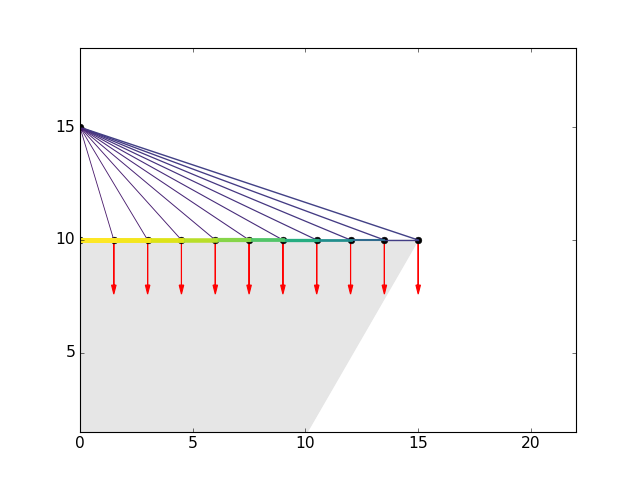

[23.095169358562927, 1.3216666666666714, 10.773502691896258, 11]

In [216]:
def ObjFuns(x,weight=[1,1,1],plot=False,text=[]):
#     print(x)
    [nodes1, beams1] = canopy(x)
    constrained_nodes = addForces(nodes1)
    solver = DirectStiffnessSolver(nodes1,beams1,constrained_nodes)
    solver.debug = False
    axial_f = solver.solveForces()
    J1 = calculate_FL(axial_f,beams1)
    J2 = calculate_shade(x)
    J3 = np.round(x[3])+1
    J = normalize_objfun([J1,J2,J3])
    sumJ = np.sum(J*np.array(weight))
    text2 = []
    if (plot):
        if (len(text) >0 ):
            text2 = ["J1 = " + str(np.round(J[0],3)),
                     "J2 = " + str(np.round(J[1],3)),
                     "J3 = " + str(J[2]),
                     "Sum_J = " + str(np.round(sumJ,2))]
        fig = plot_canopy(nodes1,beams1,axial_f,J2,text,text2)
    return [sumJ, J[0], J[1], J[2]]

def ObjFun(x,weight=[1,1,1],plot=False,text=[]):
    [sumJ, j1, j2, j3] = ObjFuns(x,weight,plot,text)
    return sumJ

ObjFuns([10.0,15.0,10.0,10],[1,1,1],True)

In [217]:
def minimize_with_weighting(weighting):
    min_res = 100
    next_best = []
    x0 = [10.0,15.0,10.0]
    for i in range(2,21):
        res = minimize(ObjFun, np.hstack([x0,i]),
                       args=(weighting,),
                       method='SLSQP',
                       bounds=((6,14),(10,20),(6,14),(2,20)),
                       options={'maxiter': 100, 'disp': False, 'eps':2.0})
        if (i == 2):
            min_res = res
            next_best = min_res
        elif (res.fun <= min_res.fun):
            next_best = min_res
            min_res = res

    min_res.x[-1] = np.round(min_res.x[-1])
    outputs = ObjFuns(min_res.x,weighting,False,["Weighting: " + str(weighting), 
                                      "Min @ X = " + str(np.round(min_res.x,2))])
    return outputs


weights = [[1,0,0],
           [0,1,0],
           [0,0,1],
           [0.5,0.5,0],
           [0.5,0,0.5],
           [0,0.5,0.5],
           [0.4,0.4,0.2],
           [0.4,0.2,0.4],
           [0.2,0.4,0.4],
           [0.333,0.333,0.333]]

values = []
for weight in weights:
    values.append(minimize_with_weighting(weight))
values = np.array(values)
values

array([[  0.45105931,   0.45105931,  17.00054532,  21.        ],
       [  3.46410162,   2.29653333,   3.46410162,  21.        ],
       [  3.        ,   2.04166667,  10.77350269,   3.        ],
       [  2.41353229,   1.36296296,   3.46410162,  21.        ],
       [  1.81622389,   0.63244778,  16.01354416,   3.        ],
       [  3.23205081,   3.83333333,   3.46410162,   3.        ],
       [  2.84638139,   2.15185185,   3.46410162,   3.        ],
       [  2.75356106,   2.15185185,   3.46410162,   3.        ],
       [  3.01601102,   2.15185185,   3.46410162,   3.        ],
       [  2.8691125 ,   2.15185185,   3.46410162,   3.        ]])

<IPython.core.display.Javascript object>


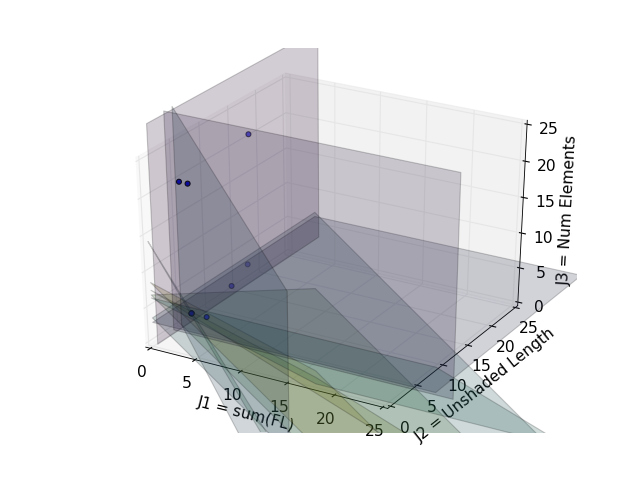

In [218]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sumj_opt = values[:,0]
j1_opt = values[:,1]
j2_opt = values[:,2]
j3_opt = values[:,3]
js = values[:,1:]

ax.scatter(j1_opt,j2_opt,j3_opt,s=20)

colors = plt.cm.viridis(np.linspace(0,1,len(sumj_opt)))
for i,j in enumerate(js):
    point = j
    normal = weights[i]

    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -np.sum(point*normal)# dot product

    # calculate corresponding z
    if (normal[2] > 0):
        xx, yy = np.meshgrid(np.linspace(0,30,10), np.linspace(0,30,10))
        z = (-normal[0]*xx - normal[1]*yy - d)*1./normal[2]
        ax.plot_surface(xx,yy,z, color=colors[i], alpha=0.2)
    elif (normal[1] > 0):
        xx, zz = np.meshgrid(np.linspace(0,30,10), np.linspace(0,30,10))
        y = (-normal[0]*xx - normal[2]*zz - d)*1./normal[1]
        ax.plot_surface(xx,y,zz, color=colors[i], alpha=0.2)
    elif (normal[0] > 0):
        yy, zz = np.meshgrid(np.linspace(0,30,10), np.linspace(0,30,10))
        x = (-normal[1]*yy - normal[2]*zz - d)*1./normal[0]
        ax.plot_surface(x,yy,zz, color=colors[i], alpha=0.2)

ax.set_xlabel('J1 = sum(FL)')
ax.set_ylabel('J2 = Unshaded Length')
ax.set_zlabel('J3 = Num Elements')
ax.set_xlim([0,25])
ax.set_ylim([0,25])
ax.set_zlim([0,25])

plt.show()

In [219]:
x1 = np.linspace(6.0,14.0,8)
x2 = np.linspace(10.0,20.0,8)
x3 = np.linspace(6.0,14.0,8)
x4 = np.linspace(2,20,8)

[xx1, xx2, xx3, xx4] = np.meshgrid(x1,x2,x3,x4)
[sumjj, jj1, jj2, jj3] = np.meshgrid(x1,x2,x3,x4)

best_j1 = 100
best_j2 = 100
best_j3 = 100
jjs = []
for i in range(len(x1)):
    for j in range(len(x2)):
        for k in range(len(x3)):
            for m in range(len(x4)):
                x1tmp = xx1[m][k][j][i]
                x2tmp = xx2[m][k][j][i]
                x3tmp = xx3[m][k][j][i]
                x4tmp = xx4[m][k][j][i]
                [sumj,j1,j2,j3] = ObjFuns([x1tmp,x2tmp,x3tmp,x4tmp],False)
                sumjj[m][k][j][i] = sumj
                jj1[m][k][j][i] = j1
                jj2[m][k][j][i] = j2
                jj3[m][k][j][i] = j3
                jjs.append([j1,j2,j3])
                            
jjs = np.array(jjs)

In [220]:
#find the bi-objective pareto points
bi_pareto_set1 = []
bi_pareto_set2 = []
bi_pareto_set3 = []

sort_indices1 = np.argsort(jjs[:,0])
sort_indices2 = np.argsort(jjs[:,1])
sort_indices3 = np.argsort(jjs[:,2])

bi_pareto_set1.append(sort_indices1[0])
bi_pareto_set2.append(sort_indices2[0])
bi_pareto_set3.append(sort_indices3[0])

min_j1 = jjs[sort_indices3[0],0]
min_j2 = jjs[sort_indices1[0],1]
min_j3 = jjs[sort_indices2[0],2]

for index in sort_indices1:
    if (jjs[index,1] <= min_j2):
        bi_pareto_set1.append(index)
        min_j2 = jjs[index,1]

for index in sort_indices2:
    if (jjs[index,2] <= min_j3):
        bi_pareto_set2.append(index)
        min_j3 = jjs[index,2]
            
for index in sort_indices3:
    if (jjs[index,0] <= min_j1):
        bi_pareto_set3.append(index)
        min_j1 = jjs[index,0]

<IPython.core.display.Javascript object>


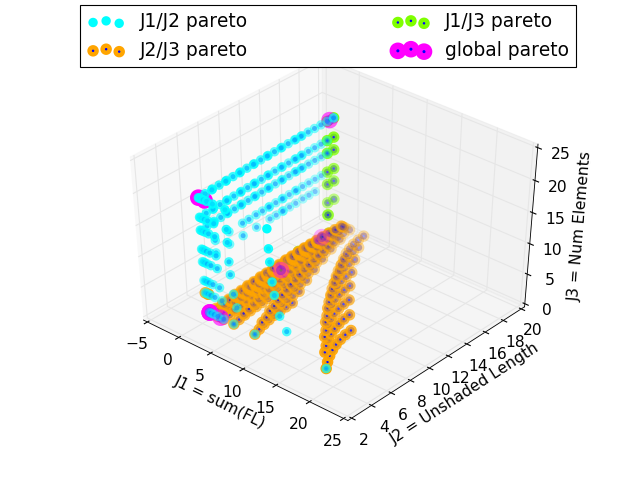

In [221]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(jj1,jj2,jj3,s=10,alpha=0.2)
ax.scatter(jjs[bi_pareto_set1,0],jjs[bi_pareto_set1,1],jjs[bi_pareto_set1,2],color='cyan',lw=4,label='J1/J2 pareto')
ax.scatter(jjs[bi_pareto_set2,0],jjs[bi_pareto_set2,1],jjs[bi_pareto_set2,2],s=40,color='orange',lw=4,label='J2/J3 pareto')
ax.scatter(jjs[bi_pareto_set3,0],jjs[bi_pareto_set3,1],jjs[bi_pareto_set3,2],s=40,color='chartreuse',lw=4,label='J1/J3 pareto')
ax.scatter(j1_opt,j2_opt,j3_opt,s=80,color='magenta',lw=6,label='global pareto')


# ax.legend(['J1/J2 pareto','J2/J3 pareto','J1/J3 pareto','global pareto'],loc=2)
ax.set_xlabel('J1 = sum(FL)')
ax.set_ylabel('J2 = Unshaded Length')
ax.set_zlabel('J3 = Num Elements')
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.)
plt.legend(bbox_to_anchor=(0, 0.95, 1.0, .1), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

<IPython.core.display.Javascript object>


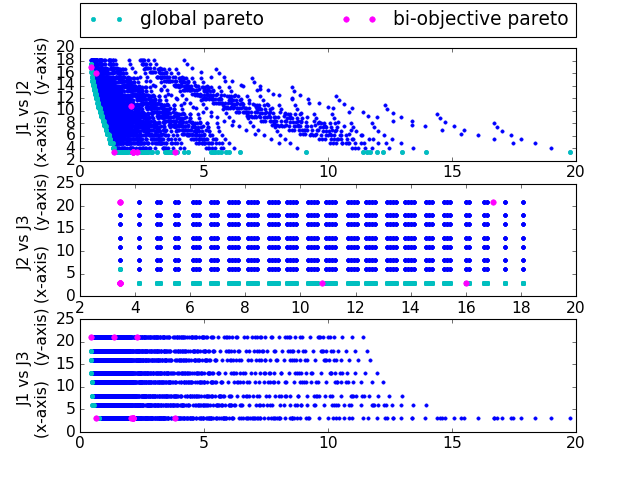

In [222]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(311)
ax.plot(jjs[:,0],jjs[:,1],'.')
ax.set_ylabel('J1 vs J2 \n (x-axis)   (y-axis)')
ax.plot(jjs[bi_pareto_set1,0],jjs[bi_pareto_set1,1],'c.',markersize=8,label='bi-objective pareto')
ax.plot(j1_opt,j2_opt,'.',color='magenta',markersize=10,label='global pareto')
ax = fig.add_subplot(312)
ax.plot(jjs[:,1],jjs[:,2],'.')
ax.set_ylabel('J2 vs J3 \n (x-axis)   (y-axis)')
ax.plot(jjs[bi_pareto_set2,1],jjs[bi_pareto_set2,2],'c.',markersize=8)
ax.plot(j2_opt,j3_opt,'.',color='magenta',markersize=10)
ax = fig.add_subplot(313)
ax.plot(jjs[:,0],jjs[:,2],'.')
ax.set_ylabel('J1 vs J3 \n (x-axis)   (y-axis)')
ax.plot(jjs[bi_pareto_set3,0],jjs[bi_pareto_set3,2],'.',color='c',markersize=8,label='global pareto')
ax.plot(j1_opt,j3_opt,'.',color='magenta',markersize=10,label='bi-objective pareto')
plt.legend(bbox_to_anchor=(0, 3.5, 1.0, .1), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [223]:
pareto_set = []
sort_indices1 = np.argsort(jjs[:,0])
sort_indices2 = np.argsort(jjs[:,1])
sort_indices3 = np.argsort(jjs[:,2])

pareto_set.append(sort_indices1[0])
pareto_set.append(sort_indices2[0])
pareto_set.append(sort_indices3[0])

min_j1 = jjs[sort_indices3[0],0]
min_j2 = jjs[sort_indices1[0],1]
min_j3 = jjs[sort_indices2[0],2]

for index in sort_indices1:
    if (jjs[index,1] <= min_j2 and jjs[index,2] <= min_j3):
        pareto_set.append(index)
        min_j2 = jjs[index,1]
        min_j3 = jjs[index,2]
        
min_j1 = jjs[sort_indices3[0],0]
min_j2 = jjs[sort_indices1[0],1]
min_j3 = jjs[sort_indices2[0],2]

for index in sort_indices2:
    if (jjs[index,1] <= min_j3 and jjs[index,0] <= min_j1):
        pareto_set.append(index)
        min_j1 = jjs[index,0]
        min_j3 = jjs[index,2]

min_j1 = jjs[sort_indices3[0],0]
min_j2 = jjs[sort_indices1[0],1]
min_j3 = jjs[sort_indices2[0],2]
        
for index in sort_indices3:
    if (jjs[index,1] <= min_j2 and jjs[index,0] <= min_j1):
        pareto_set.append(index)
        min_j2 = jjs[index,1]
        min_j1 = jjs[index,0]

pareto_set = np.unique(pareto_set)

In [182]:
jjs[pareto_set,:]

array([[  0.76296296,  13.46410162,   3.        ],
       [  2.15185185,   3.46410162,   3.        ],
       [  2.44718615,   3.46410162,   3.        ],
       [  2.85278622,   3.46410162,   3.        ],
       [  3.43650794,   3.46410162,   3.        ],
       [  4.33625192,   3.46410162,   3.        ],
       [  5.88178054,   3.46410162,   3.        ],
       [  9.10634921,   3.46410162,   3.        ],
       [ 19.76666667,   3.46410162,   3.        ],
       [  0.62592593,  13.46410162,   6.        ],
       [  0.72569917,  12.03553019,   6.        ],
       [  0.83877551,  10.60695876,   6.        ],
       [  0.96515495,   9.17838733,   6.        ],
       [  1.10483749,   7.7498159 ,   6.        ],
       [  1.25782313,   6.32124447,   6.        ],
       [  1.42411187,   4.89267304,   6.        ],
       [  1.6037037 ,   3.46410162,   6.        ],
       [  1.80582857,   3.46410162,   6.        ],
       [  2.08558055,   3.46410162,   6.        ],
       [  0.58446863,  14.12393

In [230]:
# get bounds
j1_max = np.max(jj1)
j1_min = np.min(jj1)
j2_max = np.max(jj2)
j2_min = np.min(jj2)
j3_max = np.max(jj3)
j3_min = np.min(jj3)

print("J1: " + str(np.round(j1_min,2)) + " --> " + str(np.round(j1_max,2)))
print("J2: " + str(np.round(j2_min,2)) + " --> " + str(np.round(j2_max,2)))
print("J3: " + str(np.round(j3_min,2)) + " --> " + str(np.round(j3_max,2)))

J1: 13.54 --> 593.0
J2: 3.46 --> 18.08
J3: 3.0 --> 21.0


<IPython.core.display.Javascript object>


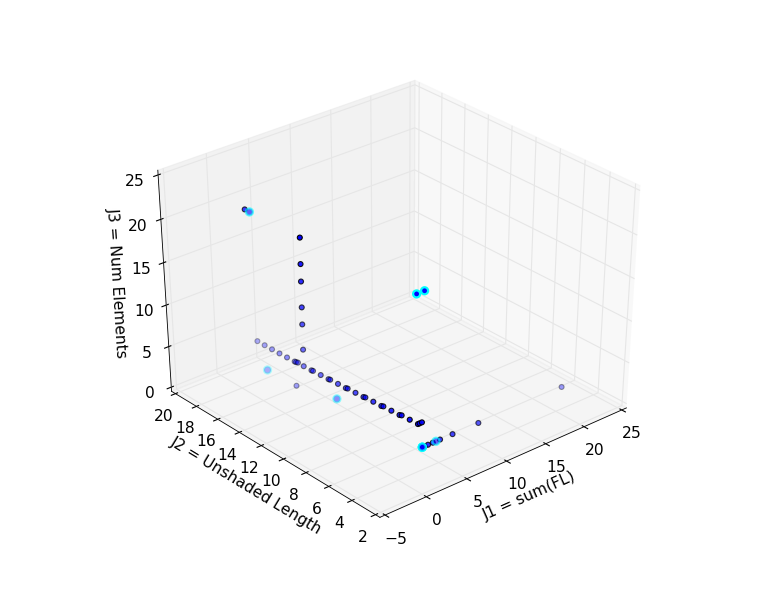

In [224]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(j1_opt,j2_opt,j3_opt,s=40,color='cyan',lw=2)

# ax.scatter(jj1,jj2,jj3)
ax.scatter(jjs[pareto_set,0],jjs[pareto_set,1],jjs[pareto_set,2],s=20)
ax.set_xlabel('J1 = sum(FL)')
ax.set_ylabel('J2 = Unshaded Length')
ax.set_zlabel('J3 = Num Elements')
plt.show()